# Particle Tracking Code

In [198]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python

%matplotlib inline
import mpld3 #For making nice looking plots
mpld3.enable_notebook()
import matplotlib
from matplotlib import pylab

#For making interactive user interfaces (buttons and sliders and such)
import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

#Loading the particle tracking software
import sys
sys.path.append("Z:\\Code\\BeadTracking\\track") #Locate code
import mpretrack
import trackmem
import tiff_file #Ignore any warnings importing this may cause

In [199]:
#Now let's locate the data
data_directory = "Z:\\381W\\Fall2017_381W\\ExampleData\\Image_1250nmSilica_3\\"
data_file = "Image_1250nmSilica_3_2x2_MedianSubtract.tif"


-----------TEST-----------
3 features found.
Intensity of 1st particle: 14341.35
Rg of 1st particle: 12.82
Eccentricity of 1st particle: 0.0298
[[  3.39104691e+01   7.81190851e+01   1.43413455e+04   1.28152874e+01
    2.98138333e-02]
 [  1.91212379e+02   1.43060893e+02   1.48162553e+04   1.28065859e+01
    1.46876546e-02]
 [  1.42885825e+02   1.85084490e+02   1.50743597e+04   1.30936580e+01
    5.52811526e-03]]
3 features kept.
Minimum Intensity : 14341.3454598
Maximum Rg : 13.0936579657
Maximum Eccentricity : 0.0298138333021
--------------------------


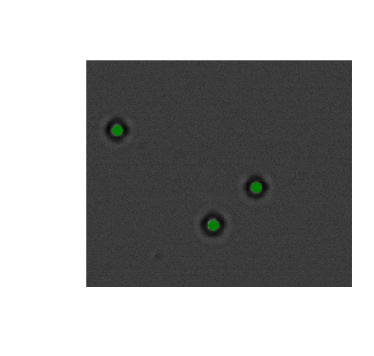

In [201]:
#Use the function 'test' in mpretrack to find good set of parameters

###############################################################################
# Options from mpretrack:
#    barI: minimum integrated intensity
#    barRg: maximum radius of gyration squared (in pixel squared)
#    barCc: minimum eccentricity accepted
#    IdivRg: minimum ratio of of integrated intensity to radius of gyr sqrd
#    Imin: minimum intensity of local max -- set to 0 to use default "top 30%"
#    masscut: threshold for integrated intesnity of features before refinement
#    field: 2 for full frame (0 or 1 if interlaced video)
###############################################################################

frame_num = 0 #We'll use the first frame
feature_size = 5
%matplotlib qt
mt, mrej = mpretrack.test(data_directory,data_file,frame_num,feature_size,
                          masscut = 1000, Imin=100, barI = 1000, barRg = 50,
                          barCc = None, IdivRg=1.0, verbose=True)

In [196]:
import feature2D
import localmax
reload(feature2D) 
reload(localmax)
reload(mpretrack)

<module 'mpretrack' from 'Z:\Code\BeadTracking\track\mpretrack.py'>

Did that look okay? You should see a figure appear with green dots where the program found particles. Red dots indicate that particles were identified but then discarded due to not meeting the thresholds (like being below the minimum integrated intensity or exceeding the maximum radius of gyration).

Now we'll run the feature-finding algorithm with the paramters we found on *all* frames.

In [203]:
num_frames = 400
mt = mpretrack.run(data_directory,data_file,num_frames,feature_size,
                   masscut = 1000, Imin=100, barI = 1000, barRg = 50,
                   barCc = None, IdivRg=1.0)

3 features found.
Frame 0
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features found.
3 features kept.
3 features f

In each frame, the code has identified particles (i.e., features). Now we have to link them together into "tracks."


In [204]:
### Tracking with fancytrack:
num_dimensions = 2 #We take 2-dimensional images
max_displacement = 8 #Maximum displacement between consecutive frames to count as same particle
goodenough = 20 #Minimum length for trajectory
memory = 1 #how many consecutive frames a feature is allowed to skip. 
tracks = trackmem.trackmem(mt, max_displacement, num_dimensions, goodenough, memory)

What's in <code>tracks</code>?
+ <code>tracks[:,5]</code> is the frame number
+ <code>tracks[:,6]</code> is the time
+ <code>tracks[:,7]</code> is the trajectory ID number

In [205]:
print "Number of trajectories: %i" % tracks[:,7].max()

Number of trajectories: 3


In [206]:
print "Length of 1st trajectory: %i" % np.sum(tracks[:,7]==1)
if tracks[:,7].max()>1:
    print "Length of 2nd trajectory: %i" % np.sum(tracks[:,7]==2)
if tracks[:,7].max()>2:
    print "Length of 3rd trajectory: %i" % np.sum(tracks[:,7]==3)

Length of 1st trajectory: 400
Length of 2nd trajectory: 400
Length of 3rd trajectory: 400


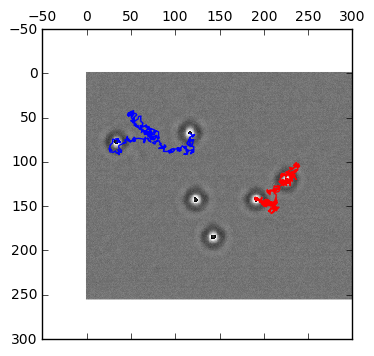

In [207]:
%matplotlib inline
mpld3.enable_notebook()
frame1_image = tiff_file.imread(data_directory+data_file,key=0)
frameLast_image = tiff_file.imread(data_directory+data_file,key=-1)
pylab.matshow(frame1_image + frameLast_image, cmap=matplotlib.cm.gray)
w = np.where(tracks[:,7]==1) #Locate track #1
pylab.plot(tracks[w[0],0],tracks[w[0],1],'-b')
if tracks[:,7].max()>1:
    w = np.where(tracks[:,7]==2) #Locate track #2
    pylab.plot(tracks[w[0],0],tracks[w[0],1],'-r')

In [208]:
track_IDs_Length = np.zeros((int(tracks[:,7].max()),2)) #Array of track ID numbers and length of those tracks
for i in range(1,int(tracks[:,7].max()+1)):
    w = np.where(tracks[:,7]==i)
    track_IDs_Length[i-1,0] = i
    track_IDs_Length[i-1,1] = len(w[0])
    
total_sd = np.zeros((num_frames)) #total squared displacements
num_sd = np.zeros((num_frames)) #number of squared displacements
len_cutoff = 12
for i in range(0,len(track_IDs_Length)):
    if track_IDs_Length[i,1]>len_cutoff:
        w = np.where(tracks[:,7]==track_IDs_Length[i,0])
        xys = tracks[w[0],0:2] #x- and y-positions
        for j in range(1,xys.shape[0]-1):
            xdiff = xys[j:,0]-xys[0:-1*(j),0]
            ydiff = xys[j:,1]-xys[0:-1*(j),1]
            squared_displacement = xdiff**2 + ydiff**2
            total_sd[j-1] = total_sd[j-1] + squared_displacement.sum()
            num_sd[j-1] = num_sd[j-1] + len(squared_displacement)

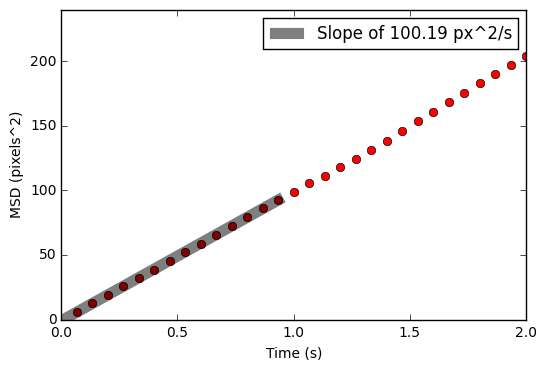

In [231]:
w = np.where(num_sd>0)
msd = total_sd[w]/num_sd[w]
frame_rate = 15.0
times = np.arange(1,len(msd)+1)/frame_rate
w = np.where(times<1.0) #Find where time is less than 1 second
pylab.plot(times, msd,'ro')
pfit = np.polyfit(times[w], msd[w],1)
pylab.plot(np.hstack((np.array([0]),times[w])), np.polyval(pfit, np.hstack((np.array([0]),times[w]))), 
           '-k', lw=8, alpha=0.5, label = r"Slope of %.2f px^2/s" % pfit[0])
pylab.xlim(0,2)
pylab.ylim(0,240)
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('MSD (pixels^2)')